## Cell type specificity analysis: Perturbation Mean Prediction Model

In [20]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import glob

from pathlib import Path

def filter_keep_single_celltype(file_list):
    return [
        f for f in file_list
        if (
            Path(f).name == 'C3A_results.csv' or
            not ((parts := Path(f).stem.replace('_results', '').split('_')) and len(parts) == 2 and parts[0] == parts[1])
        )
    ]

In [21]:
sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_results.csv')
sts_file_names = filter_keep_single_celltype(sts_file_names)
sts_file_names = [f for f in sts_file_names if 'agg' not in f]
sts_cell_names = [x.split('/')[-1].split('_')[0] for x in sts_file_names]
sts_name_dict = {x:y for x,y in zip(sts_cell_names, sts_file_names)}

ct_mean_file_names =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_celltypemean/holdout/eval_final.ckpt/*_results.csv')
ct_mean_file_names = filter_keep_single_celltype(ct_mean_file_names)
ct_mean_file_names = [f for f in ct_mean_file_names if 'agg' not in f]
ct_mean_cell_names = [x.split('/')[-1].split('_')[0] for x in ct_mean_file_names]
ct_mean_name_dict = {x:y for x,y in zip(ct_mean_cell_names, ct_mean_file_names)}

pert_mean_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_globalsimplesum/holdout/eval_final.ckpt/*_results.csv')
pert_mean_file_names = filter_keep_single_celltype(pert_mean_file_names)
pert_mean_file_names = [f for f in pert_mean_file_names if 'agg' not in f]
pert_mean_cell_names = [x.split('/')[-1].split('_')[0] for x in pert_mean_file_names]
pert_mean_name_dict = {x:y for x,y in zip(pert_mean_cell_names, pert_mean_file_names)}


In [22]:
#for k, files_ in files.items():
#    files[k] = [f for f in files_ if 'agg' not in f]

In [23]:
#/large_storage/ctc/userspace/aadduri/preprint_redo/globalsimplesum_cs256_2000_braf/holdout/eval_final.ckpt/*_results.csv
#/large_storage/ctc/userspace/aadduri/preprint_redo/celltypemean_cs256_2000_braf/holdout/eval_final.ckpt/*_results.csv

In [24]:
## For all cell types

def get_dfs(cell_name_dict, col_name):
    value_dfs = []
    
    for cell_name, cell_file_name in cell_name_dict.items():
        ## pull out DE spearman result for State set runs
        df = pd.read_csv(cell_file_name)
        
        ## pull out DE spearman result for mean baselines
        value_df = df.set_index('perturbation').loc[:,[col_name]]
        value_df['cell_type'] = cell_name
    
        value_dfs.append(value_df)

    return pd.concat(value_dfs)

def get_merged_mean_df(metric_name):
    sts_dfs = []
    cell_type_mean_dfs = []
    pert_mean_dfs = []
    
    sts_dfs = get_dfs(sts_name_dict, col_name=metric_name)
    ct_mean_dfs = get_dfs(ct_mean_name_dict, col_name=metric_name)
    pert_mean_dfs = get_dfs(pert_mean_name_dict, col_name=metric_name)
    
    ## Identify interesting examples showing big deviation
    
    merged_df = sts_dfs.merge(ct_mean_dfs, on=['perturbation','cell_type'], suffixes=('_sts','_ct'))
    merged_df = merged_df.merge(pert_mean_dfs, on=['perturbation','cell_type'])
    merged_df = merged_df.rename(columns={metric_name:metric_name+'_pert'})
    
    merged_mean_df = merged_df.drop('cell_type', axis=1).groupby('perturbation').mean()
    
    merged_mean_df['sts-ct'] = merged_mean_df[metric_name+'_sts'] - merged_mean_df[metric_name+'_ct']
    merged_mean_df['sts-pert'] = merged_mean_df[metric_name+'_sts'] - merged_mean_df[metric_name+'_pert']
    
    merged_mean_df['mean_increment'] = [np.mean([x,y]) for x,y in zip(merged_mean_df['sts-ct'], merged_mean_df['sts-pert'])]

    return merged_mean_df
    

In [25]:
metrics = ['overlap_at_N', 'de_spearman_lfc_sig']

In [26]:
merged_mean_dfs = []

for metric in metrics:
    merged_mean_dfs.append(get_merged_mean_df(metric))

merged_mean_df = merged_mean_dfs[0].merge(merged_mean_dfs[1], left_index=True, right_index=True)

In [27]:
merged_mean_df_subset = merged_mean_df[merged_mean_df['overlap_at_N_sts']>0.5]
merged_mean_df_subset = merged_mean_df_subset[merged_mean_df_subset['de_spearman_lfc_sig_sts']>0.75]
merged_mean_df_subset

,overlap_at_N_sts,overlap_at_N_ct,overlap_at_N_pert,sts-ct_x,sts-pert_x,mean_increment_x,de_spearman_lfc_sig_sts,de_spearman_lfc_sig_ct,de_spearman_lfc_sig_pert,sts-ct_y,sts-pert_y,mean_increment_y
perturbation,,,,,,,,,,,,
"[('Budesonide', 0.05, 'uM')]",0.579948,0.203772,0.270885,0.376176,0.309063,0.342619,0.754733,0.690663,0.234611,0.064070,0.520121,0.292095
"[('Darolutamide', 0.5, 'uM')]",0.579760,0.124588,0.283382,0.455172,0.296377,0.375775,0.754977,0.662385,0.435976,0.092592,0.319001,0.205796
"[('Epirubicin (hydrochloride)', 5.0, 'uM')]",0.517390,0.400250,0.463420,0.117140,0.053970,0.085555,0.785472,0.600693,0.102844,0.184778,0.682628,0.433703
"[('Fumaric acid', 5.0, 'uM')]",0.549595,0.169132,0.229192,0.380463,0.320403,0.350433,0.777949,0.775104,0.509594,0.002845,0.268355,0.135600
"[('Homoharringtonine', 0.5, 'uM')]",0.623756,0.362859,0.531697,0.260898,0.092059,0.176478,0.756122,0.410221,0.438570,0.345901,0.317552,0.331727
"[('Idarubicin (hydrochloride)', 5.0, 'uM')]",0.687314,0.623293,0.660188,0.064020,0.027126,0.045573,0.811104,0.419587,0.598075,0.391517,0.213029,0.302273
"[('Ouabain (Octahydrate)', 0.5, 'uM')]",0.601327,0.171356,0.388600,0.429971,0.212727,0.321349,0.771971,0.528793,0.312632,0.243178,0.459339,0.351259
"[('Sulfatinib', 5.0, 'uM')]",0.519797,0.139598,0.236967,0.380199,0.282830,0.331514,0.762691,0.673600,0.384592,0.089091,0.378099,0.233595
"[('Tazarotene', 0.5, 'uM')]",0.510737,0.315356,0.365274,0.195381,0.145463,0.170422,0.767806,0.693788,-0.106672,0.074018,0.874478,0.474248


In [28]:
(merged_mean_df_subset['mean_increment_x'] + merged_mean_df_subset['mean_increment_y']).sort_values()[-50:]

perturbation
[('Idarubicin (hydrochloride)', 5.0, 'uM')]       0.347846
[('Fumaric acid', 5.0, 'uM')]                     0.486032
[('Homoharringtonine', 0.5, 'uM')]                0.508205
[('Epirubicin (hydrochloride)', 5.0, 'uM')]       0.519258
[('Sulfatinib', 5.0, 'uM')]                       0.565109
[('Darolutamide', 0.5, 'uM')]                     0.581571
[('Zileuton', 0.5, 'uM')]                         0.585359
[('Trametinib (DMSO_TF solvate)', 0.05, 'uM')]    0.621367
[('Trametinib (DMSO_TF solvate)', 0.5, 'uM')]     0.634672
[('Budesonide', 0.05, 'uM')]                      0.634715
[('Tazarotene', 0.5, 'uM')]                       0.644670
[('Trametinib', 0.5, 'uM')]                       0.659742
[('Ouabain (Octahydrate)', 0.5, 'uM')]            0.672608
dtype: float64

In [29]:
##sel_pert = "[('Berbamine', 0.05, 'uM')]"
##sel_pert = "[('Everolimus', 5.0, 'uM')]"
## sel_pert = "[('Tofacitinib', 0.5, 'uM')]"
##sel_pert = "[('Tolcapone', 0.5, 'uM')]"
sel_pert = "[('Trametinib', 0.5, 'uM')]"
##sel_pert = "[('Ouabain (Octahydrate)', 0.5, 'uM')]"

/tmp/ipykernel_172340/2954376067.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


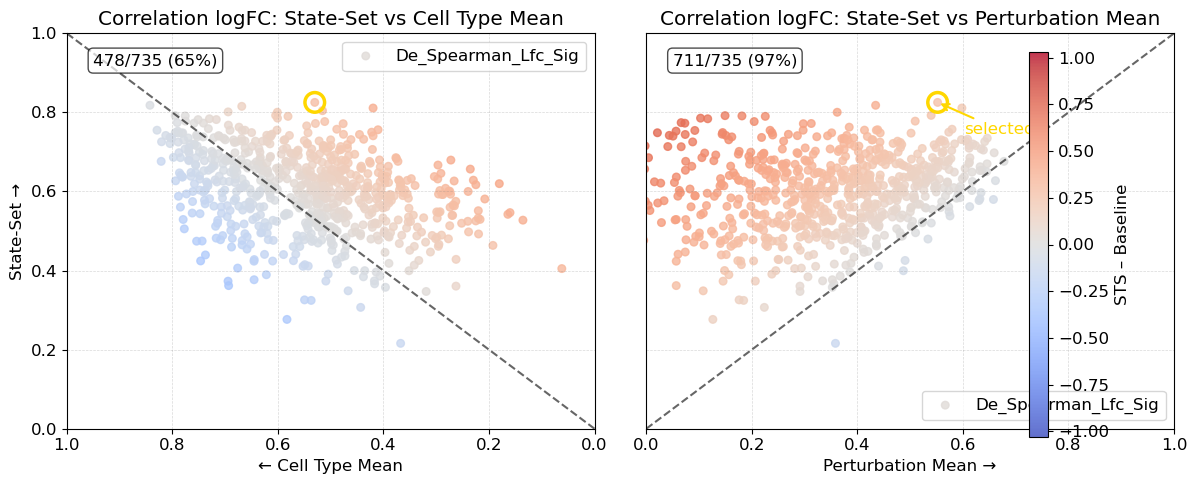

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

df = merged_mean_df

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
grid_kwargs = dict(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

for metric in metrics[1:]:
    x_ct   = df[f'{metric}_ct']
    x_pert = df[f'{metric}_pert']
    y      = df[f'{metric}_sts']
    
    # compute diffs + norm
    diff_ct   = y - x_ct
    diff_pert = y - x_pert
    max_delta = max(np.max(np.abs(diff_ct)), np.max(np.abs(diff_pert)))
    norm = TwoSlopeNorm(vmin=-max_delta, vcenter=0, vmax=+max_delta)

    # regular scatter
    sc1 = ax1.scatter(x_ct, y, c=diff_ct, cmap='coolwarm', norm=norm,
                      s=30, alpha=0.8, marker='o', label=metric.title())
    sc2 = ax2.scatter(x_pert, y, c=diff_pert, cmap='coolwarm', norm=norm,
                      s=30, alpha=0.8, marker='o', label=metric.title())

    # --- HIGHLIGHT THE sel_pert POINT ---
    if sel_pert in df.index:
        # get its coords
        x1_sel = df.at[sel_pert, f'{metric}_ct']
        x2_sel = df.at[sel_pert, f'{metric}_pert']
        y_sel  = df.at[sel_pert, f'{metric}_sts']
        
        # overplot a big gold circle
        ax1.scatter([x1_sel], [y_sel],
                    s=200, facecolors='none', edgecolors='gold', linewidth=2.5,
                    zorder=5)
        ax2.scatter([x2_sel], [y_sel],
                    s=200, facecolors='none', edgecolors='gold', linewidth=2.5,
                    zorder=5)

        # optional: add an arrow + text label
        ax2.annotate(
            "selected",
            xy=(x2_sel, y_sel),
            xytext=(x2_sel + 0.05, y_sel - 0.05),
            arrowprops=dict(arrowstyle="->", color="gold", lw=1.5),
            color="gold",
            fontsize=12,
            va="top"
        )
    # ------------------------------------

    # compute & annotate counts as before...
    is_better_ct   = diff_ct   > 0
    is_better_pert = diff_pert > 0
    cnt_ct, pct_ct     = is_better_ct.sum(),   is_better_ct.mean()
    cnt_pert, pct_pert = is_better_pert.sum(), is_better_pert.mean()

    ax1.text(0.05, 0.95,
             f"{cnt_ct}/{len(diff_ct)} ({pct_ct:.0%})",
             transform=ax1.transAxes, va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
    ax2.text(0.05, 0.95,
             f"{cnt_pert}/{len(diff_pert)} ({pct_pert:.0%})",
             transform=ax2.transAxes, va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

# finish styling…
for ax in (ax1, ax2):
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.grid(**grid_kwargs)
    ax.legend()

ax1.set_xlabel('← Cell Type Mean')
ax1.set_ylabel('State-Set →')
ax1.set_title('Correlation logFC: State-Set vs Cell Type Mean')
ax1.invert_xaxis()

ax2.set_xlabel('Perturbation Mean →')
ax2.tick_params(axis='y', which='both', labelleft=False, left=False)
ax2.set_title('Correlation logFC: State-Set vs Perturbation Mean')

cbar = fig.colorbar(sc1, ax=(ax1, ax2), fraction=0.046, pad=0.04)
cbar.set_label('STS – Baseline')

plt.tight_layout()
plt.savefig('cell_type_specificity_overlay_highlight.svg')
plt.show()


/tmp/ipykernel_172340/1587431221.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


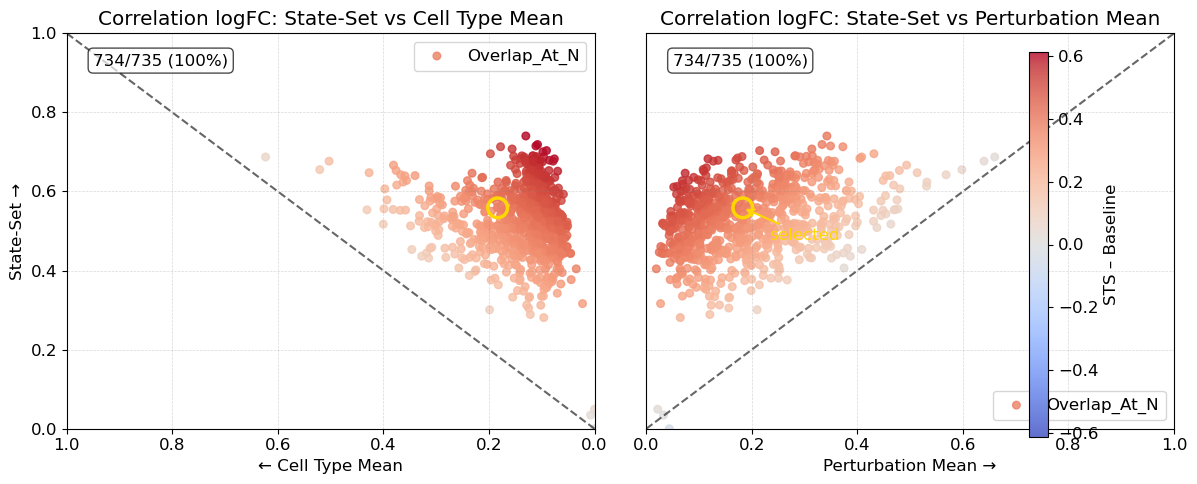

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib

df = merged_mean_df
matplotlib.rc('font', size=12)

# metrics to plot and styling (only the first metric here)
colors  = {'overlap_at_N': 'navy', 'de_spearman_lfc_sig': 'navy'}
markers = {'overlap_at_N': 'o',  'de_spearman_lfc_sig': 'o'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
grid_kwargs = dict(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

for metric in metrics[:1]:
    x_ct   = df[f'{metric}_ct']
    x_pert = df[f'{metric}_pert']
    y      = df[f'{metric}_sts']
    
    # compute differences
    diff_ct   = y - x_ct
    diff_pert = y - x_pert
    
    # symmetric normalization around zero
    max_delta = max(np.max(np.abs(diff_ct)), np.max(np.abs(diff_pert)))
    norm = TwoSlopeNorm(vmin=-max_delta, vcenter=0, vmax=+max_delta)
    
    # scatter, coloring by how much STS beats baseline
    sc1 = ax1.scatter(
        x_ct, y,
        c=diff_ct, cmap='coolwarm', norm=norm,
        s=30, alpha=0.8,
        marker=markers[metric],
        label=metric.title()
    )
    sc2 = ax2.scatter(
        x_pert, y,
        c=diff_pert, cmap='coolwarm', norm=norm,
        s=30, alpha=0.8,
        marker=markers[metric],
        label=metric.title()
    )
    
    # --- HIGHLIGHT sel_pert exactly as before ---
    if sel_pert in df.index:
        x1_sel = df.at[sel_pert, f'{metric}_ct']
        x2_sel = df.at[sel_pert, f'{metric}_pert']
        y_sel  = df.at[sel_pert, f'{metric}_sts']
        # big gold ring
        ax1.scatter([x1_sel], [y_sel],
                    s=200, facecolors='none', edgecolors='gold', linewidth=2.5,
                    zorder=5)
        ax2.scatter([x2_sel], [y_sel],
                    s=200, facecolors='none', edgecolors='gold', linewidth=2.5,
                    zorder=5)
        # arrow + label
        ax2.annotate(
            "selected",
            xy=(x2_sel, y_sel),
            xytext=(x2_sel + 0.05, y_sel - 0.05),
            arrowprops=dict(arrowstyle="->", color="gold", lw=1.5),
            color="gold",
            fontsize=12,
            va="top"
        )
    # ------------------------------------
    
    # compute counts & percentages and annotate
    is_better_ct   = diff_ct   > 0
    is_better_pert = diff_pert > 0
    cnt_ct, pct_ct     = is_better_ct.sum(),   is_better_ct.mean()
    cnt_pert, pct_pert = is_better_pert.sum(), is_better_pert.mean()
    
    ax1.text(
        0.05, 0.95,
        f"{cnt_ct}/{len(diff_ct)} ({pct_ct:.0%})",
        transform=ax1.transAxes,
        va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
    )
    ax2.text(
        0.05, 0.95,
        f"{cnt_pert}/{len(diff_pert)} ({pct_pert:.0%})",
        transform=ax2.transAxes,
        va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
    )

# unity line, grid, legend
for ax in (ax1, ax2):
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(**grid_kwargs)
    ax.legend()

# labels & titles
ax1.set_xlabel('← Cell Type Mean')
ax1.set_ylabel('State-Set →')
ax1.set_title('Correlation logFC: State-Set vs Cell Type Mean')
ax1.invert_xaxis()

ax2.set_xlabel('Perturbation Mean →')
ax2.tick_params(axis='y', which='both', labelleft=False, left=False)
ax2.set_title('Correlation logFC: State-Set vs Perturbation Mean')

# shared colorbar
cbar = fig.colorbar(sc1, ax=(ax1, ax2), fraction=0.046, pad=0.04)
cbar.set_label('STS – Baseline')

plt.tight_layout()
plt.savefig('cell_type_specificity_overlay_annotated.svg')
plt.show()


In [32]:
def log_with_check(x, neg=False, base=10, no_epsilon=False):
    res = []
    for xi in x:
        if xi <= 0:
            if no_epsilon:
                return 0
            res.append(0+5e-4)
        elif xi != xi:
            res.append(0+5e-4)
        else:
            if base==10:
                val=np.log10(xi)
            elif base==2:
                val=np.log2(xi)
            if neg:
                val=-val
            res.append(val)
    return res

def subset_DE_to_pert(DE_df, sel_pert, sig_genes=None):
    df = DE_df[DE_df['target'] == sel_pert]
    if sig_genes is not None:
        df = df.loc[sig_genes]
    else:
        sig_genes = df[df['fdr']<0.05].index.values
        df = df.loc[sig_genes]
    return df

### Deep-dive on one example

In [33]:
sts_file_names

['/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/Hs 766T_results.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/C3A_results.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/HOP62_results.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/C32_results.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/PANC-1_results.csv']

In [34]:
pred_DE = pd.read_csv('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/C32_pred_de.csv')
true_DE = pd.read_csv('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/C32_real_de.csv')

pert_mean_DE = pd.read_csv('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_globalsimplesum/holdout/eval_final.ckpt/C32_pred_de.csv')
ct_mean_DE = pd.read_csv('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_celltypemean/holdout/eval_final.ckpt/C32_pred_de.csv')

In [40]:
pert_mean_DE['fdr'].value_counts()

fdr
0.000000e+00     1380610
1.000000e+00        2823
2.766342e-246         11
4.542164e-295          9
2.722257e-185          8
                  ...   
1.318711e-03           1
1.907435e-169          1
4.815539e-123          1
1.256009e-16           1
2.848689e-158          1
Name: count, Length: 86163, dtype: int64

In [35]:
true_df = true_DE[true_DE['target'] == sel_pert]
sig_genes = true_df[true_df['fdr']<0.05].index.values

pred_df = pred_DE[pred_DE['target'] == sel_pert]
pert_mean_df =  pert_mean_DE[pert_mean_DE['target'] == sel_pert]
ct_mean_df =  ct_mean_DE[ct_mean_DE['target'] == sel_pert]

true_df = true_DE.loc[sig_genes]
pred_df = pred_df.loc[sig_genes]
ct_mean_df = ct_mean_df.loc[sig_genes]
pert_mean_df = pert_mean_df.loc[sig_genes]


In [36]:
pred_df['log_fold_change'] = log_with_check(pred_df['fold_change'])
true_df['log_fold_change'] = log_with_check(true_df['fold_change'])

pert_mean_df['log_fold_change'] = log_with_check(pert_mean_df['fold_change'])
ct_mean_df['log_fold_change'] = log_with_check(ct_mean_df['fold_change'])

In [37]:
pert_mean_df['fdr'].values

array([0.00000000e+000, 2.66555285e-239, 0.00000000e+000, 2.17191037e-215,
       2.59400048e-005, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       5.02544278e-210, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       8.47574802e-174, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.06585924e-034, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.59551012e-176, 0.00000000e+000,
       8.76671747e-135, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       8.98080365e-187, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 8.30543922e-178, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 6

/tmp/ipykernel_172340/2521027020.py:6: RuntimeWarning: divide by zero encountered in log10
  x = -np.log10(true_df['fdr'].values)


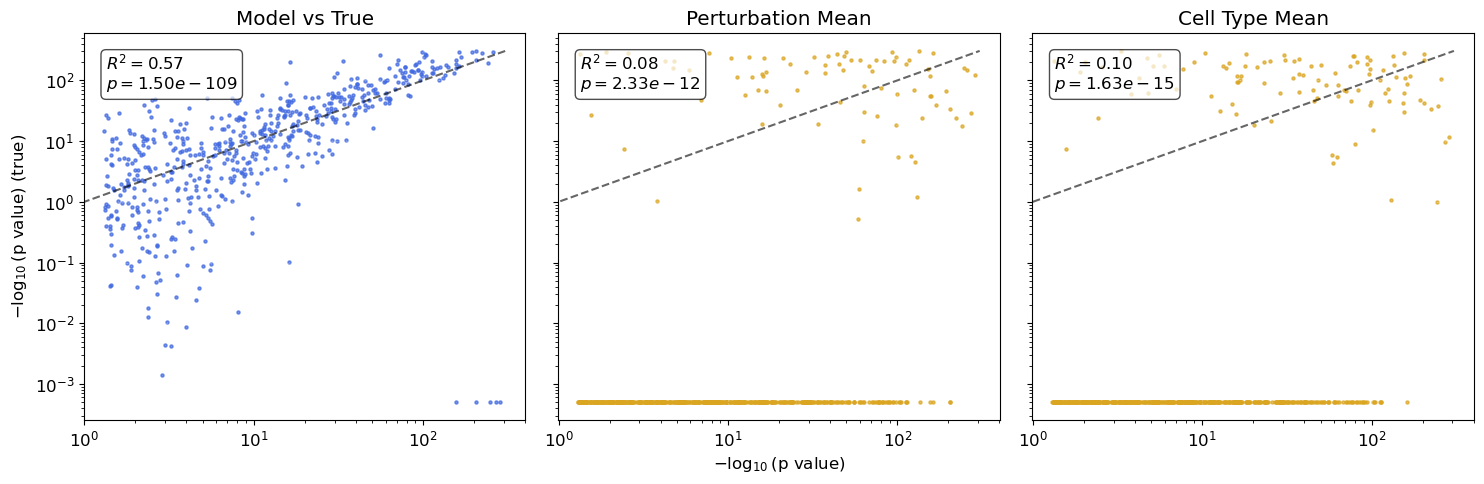

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# compute –log10 p-values for true data
x = -np.log10(true_df['fdr'].values)
x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

# compute –log10 p-values for predictions
y_pred = np.array(log_with_check(pred_df['fdr'].values, neg=True))
y_pert = np.array(log_with_check(pert_mean_df['fdr'].values, neg=True))
y_ct   = np.array(log_with_check(ct_mean_df['fdr'].values, neg=True))

# global limits
lims = (min(x.tolist() + y_pred.tolist() + y_pert.tolist() + y_ct.tolist()), 
        max(x.tolist() + y_pred.tolist() + y_pert.tolist() + y_ct.tolist()))

# set up 1×3 grid of subplots sharing both axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# common grid style
grid_kwargs = dict(color='white', linestyle='--', linewidth=0.5, alpha=0.3)

# titles and y-data
panels = [
    ('Model vs True',       y_pred, 'royalblue'),
    ('Perturbation Mean',   y_pert, 'goldenrod'),
    ('Cell Type Mean',      y_ct,   'goldenrod'),
]

for ax, (title, y, color) in zip(axes, panels):
    ax.scatter(x, y, color=color, s=5, alpha=0.7)
    ax.plot(lims, lims, 'k--', alpha=0.6)
    
    # linear regression
    slope, intercept, r_value, p_value, stderr = linregress(x, y)
    r2 = r_value**2

    # annotate R² and p
    txt = rf'$R^2 = {r2:.2f}$' + '\n' + rf'$p = {p_value:.2e}$'
    ax.text(
        0.05, 0.95, txt,
        transform=ax.transAxes,
        va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
    )

    ax.set_title(title)
    ax.grid(**grid_kwargs)

# axis labels only on the outer plots
axes[0].set_ylabel(r'$-\log_{10}(\mathrm{p\ value})$ (true)')
axes[1].set_xlabel(r'$-\log_{10}(\mathrm{p\ value})$')

axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('p-vals_gene_level_with_r2.svg')


In [24]:
len(x)

595

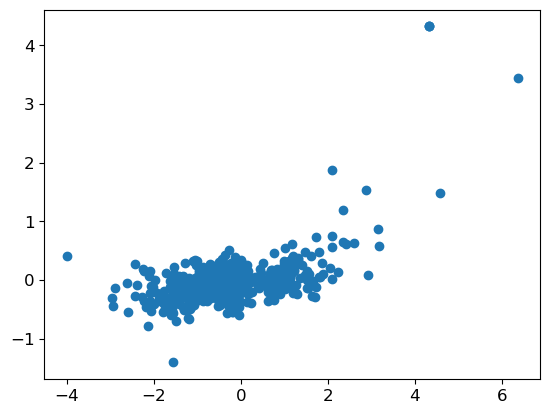

In [25]:
plt.scatter(x, y_ct)

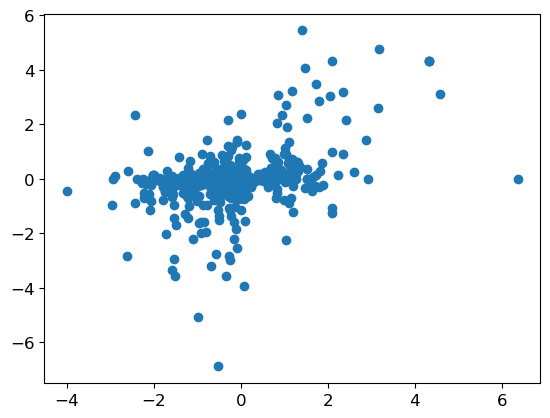

In [26]:
plt.scatter(x, y_pert)

In [ ]:
plt.scatter(x, y_)

(array([588.,   2.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.24389648e-02, 8.29994507e+00, 1.65374512e+01, 2.47749573e+01,
        3.30124634e+01, 4.12499695e+01, 4.94874756e+01, 5.77249817e+01,
        6.59624878e+01, 7.41999939e+01, 8.24375000e+01]),
 <BarContainer object of 10 artists>)

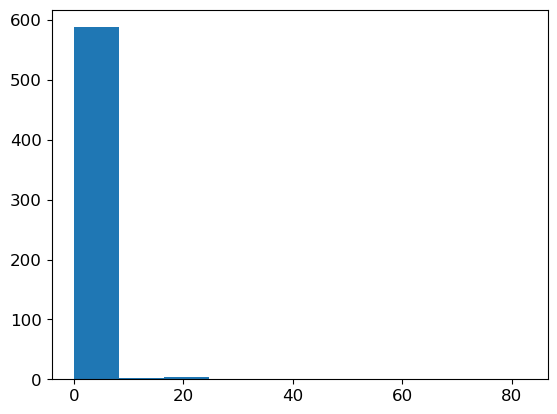

In [33]:
plt.hist(true_df['fold_change'].values)

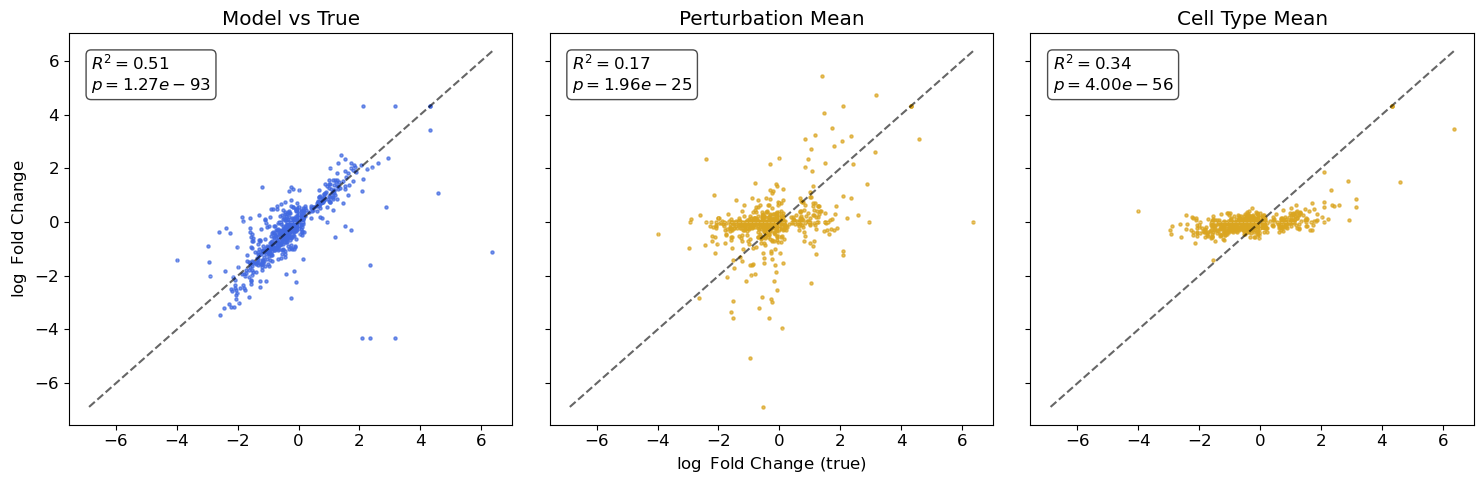

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# compute –log10 fold-changes

x = np.log2(true_df['fold_change'].values)
x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

#x = np.array(log_with_check(true_df['fold_change'].values, neg=False, base=2))

y_pred = np.array(log_with_check(pred_df['fold_change'].values, neg=False, base=2))
y_pert = np.array(log_with_check(pert_mean_df['fold_change'].values, neg=False, base=2))
y_ct   = np.array(log_with_check(ct_mean_df['fold_change'].values, neg=False, base=2))

# fixed limits for all panels
lims = (min(x.tolist() + y_pred.tolist() + y_pert.tolist() + y_ct.tolist()), 
        max(x.tolist() + y_pred.tolist() + y_pert.tolist() + y_ct.tolist()))

# set up 1×3 grid of subplots sharing both axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# common grid style
grid_kwargs = dict(color='white', linestyle='--', linewidth=0.5, alpha=0.3)

# titles and y-data
panels = [
    ('Model vs True',     y_pred, 'royalblue'),
    ('Perturbation Mean', y_pert, 'goldenrod'),
    ('Cell Type Mean',    y_ct,   'goldenrod'),
]

for ax, (title, y, color) in zip(axes, panels):
    # scatter
    ax.scatter(x, y, color=color, s=5, alpha=0.7)
    
    # 1:1 line
    ax.plot(lims, lims, 'k--', alpha=0.6)
    #ax.set_xlim(lims)
    #ax.set_ylim(lims)
    
    # linear regression
    slope, intercept, r_value, p_value, stderr = linregress(x, y)
    r2 = r_value**2
    
    # annotate R² and p
    txt = rf'$R^2 = {r2:.2f}$' + '\n' + rf'$p = {p_value:.2e}$'
    ax.text(
        0.05, 0.95, txt,
        transform=ax.transAxes,
        va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
    )
    
    ax.set_title(title)
    ax.grid(**grid_kwargs)

# axis labels only on the outer plots
axes[0].set_ylabel(r'$\log\ \mathrm{Fold\ Change}$')
axes[1].set_xlabel(r'$\log\ \mathrm{Fold\ Change\ (true)}$')

plt.tight_layout()
plt.savefig('lfc_gene_level.svg')



### Heatmap for cell type specifcity

In [149]:
from scipy.stats import hypergeom

In [150]:
pred_DEs = {}
true_DEs = {}
pert_mean_DEs = {}
ct_mean_DEs = {}

for cell_name, cell_file_name in sts_name_dict.items():
    pred_DEs[cell_name] = pd.read_csv(cell_file_name.split('_results.csv')[0] + '_pred_de.csv')
    true_DEs[cell_name] = pd.read_csv(cell_file_name.split('_results.csv')[0] + '_real_de.csv')

for cell_name, cell_file_name in ct_mean_name_dict.items():
    pert_mean_DEs[cell_name] = pd.read_csv(cell_file_name.split('_results.csv')[0] + '_pred_de.csv')

for cell_name, cell_file_name in pert_mean_name_dict.items():
    ct_mean_DEs[cell_name] = pd.read_csv(cell_file_name.split('_results.csv')[0] + '_pred_de.csv')

In [151]:
pred_dfs = {}
true_dfs = {}
ct_mean_dfs = {}
pert_mean_dfs = {}
true_sig_genes = {}

for cell_name, DE in true_DEs.items():
    # Subset true data and identify significant genes
    true_dfs[cell_name] = subset_DE_to_pert(DE, sel_pert)    
    
    #sig_genes = true_dfs[cell_name].index.values
    sig_genes = None

    # Subset predictions and means
    pred_dfs[cell_name] = subset_DE_to_pert(pred_DEs[cell_name], sel_pert, sig_genes)
    pert_mean_dfs[cell_name] = subset_DE_to_pert(pert_mean_DEs[cell_name], sel_pert, sig_genes)
    ct_mean_dfs[cell_name] = subset_DE_to_pert(ct_mean_DEs[cell_name], sel_pert, sig_genes)

    # Compute log fold changes
    pred_dfs[cell_name]['log_fold_change'] = log_with_check(pred_dfs[cell_name]['fold_change'])
    pred_dfs[cell_name]['abs_log_fold_change'] = np.abs(pred_dfs[cell_name]['log_fold_change'])
    
    true_dfs[cell_name]['log_fold_change'] = log_with_check(true_dfs[cell_name]['fold_change'])
    true_dfs[cell_name]['abs_log_fold_change'] = np.abs(true_dfs[cell_name]['log_fold_change'])
    
    pert_mean_dfs[cell_name]['log_fold_change'] = log_with_check(pert_mean_dfs[cell_name]['fold_change'])
    ct_mean_dfs[cell_name]['log_fold_change'] = log_with_check(ct_mean_dfs[cell_name]['fold_change'])

    pert_mean_dfs[cell_name]['abs_log_fold_change'] = np.abs(pert_mean_dfs[cell_name]['log_fold_change'])
    ct_mean_dfs[cell_name]['abs_log_fold_change'] = np.abs(ct_mean_dfs[cell_name]['log_fold_change'])


In [152]:
top_true = {}
top_pred = {}
top_pert_mean = {}
top_celltype_mean = {}
k = 100

for cell_name, DE in true_DEs.items():

    top_true[cell_name] = true_dfs[cell_name].sort_values('abs_log_fold_change', ascending=False)[:k]['feature'].values
    top_pred[cell_name] = pred_dfs[cell_name].sort_values('abs_log_fold_change', ascending=False)[:k]['feature'].values
    top_pert_mean[cell_name] = pert_mean_dfs[cell_name].sort_values('abs_log_fold_change', ascending=False)[:k]['feature'].values
    top_celltype_mean[cell_name] = ct_mean_dfs[cell_name].sort_values('abs_log_fold_change', ascending=False)[:k]['feature'].values




In [153]:
import itertools

def average_intersection(d: dict) -> float:
    pairs = itertools.combinations(d.values(), 2)
    intersections = [len(set(a) & set(b)) for a, b in pairs]
    return sum(intersections) / len(intersections)

In [154]:
average_intersection(top_true)

15.7

In [140]:
# Define the output file path
output_file = "intersecting_genes_per_model.txt"

# Open the file for writing
with open(output_file, "w") as f:
    for cell_name in top_true.keys():
        pred_intersect = set(top_true[cell_name]).intersection(set(top_pred[cell_name]))
        ct_mean_intersect = set(top_true[cell_name]).intersection(set(top_celltype_mean[cell_name]))
        pert_mean_intersect = set(top_true[cell_name]).intersection(set(top_pert_mean[cell_name]))

        f.write(f'{cell_name}\n')
        
        f.write(f'pred ({len(pred_intersect)}):\n')
        for gene in sorted(pred_intersect):
            f.write(f'  {gene_name_dict[gene]}\n')
        
        f.write(f'ct_mean ({len(ct_mean_intersect)}):\n')
        for gene in sorted(ct_mean_intersect):
            f.write(f'  {gene_name_dict[gene]}\n')
        
        f.write(f'pert_mean ({len(pert_mean_intersect)}):\n')
        for gene in sorted(pert_mean_intersect):
            f.write(f'  {gene_name_dict[gene]}\n')
        
        f.write('---\n')


In [139]:
gene

1611

In [146]:
# total number of HVGs and size of each top-set
N_genes = 2000
top_k   = 100

for cell_name in top_true.keys():
    # compute overlaps
    o_pred      = len(set(top_true[cell_name]) & set(top_pred[cell_name]))
    o_ct_mean   = len(set(top_true[cell_name]) & set(top_celltype_mean[cell_name]))
    o_pert_mean = len(set(top_true[cell_name]) & set(top_pert_mean[cell_name]))
    
    # hypergeometric p-values (sf = P[X >= overlap])
    p_pred      = hypergeom.sf(o_pred - 1, N_genes, top_k, top_k)
    p_ct_mean   = hypergeom.sf(o_ct_mean - 1, N_genes, top_k, top_k)
    p_pert_mean = hypergeom.sf(o_pert_mean - 1, N_genes, top_k, top_k)

    print(f"=== {cell_name} ===")
    print(f"Model vs True     : overlap = {o_pred:3d},  p = {p_pred:.2e}")
    print(f"Cell-Type Mean    : overlap = {o_ct_mean:3d},  p = {p_ct_mean:.2e}")
    print(f"Perturbation Mean : overlap = {o_pert_mean:3d},  p = {p_pert_mean:.2e}")
    print()

=== Hs 766T ===
Model vs True     : overlap =  24,  p = 1.48e-11
Cell-Type Mean    : overlap =   8,  p = 1.22e-01
Perturbation Mean : overlap =   9,  p = 5.82e-02

=== C3A ===
Model vs True     : overlap =  47,  p = 5.32e-39
Cell-Type Mean    : overlap =   5,  p = 5.68e-01
Perturbation Mean : overlap =   4,  p = 7.49e-01

=== HOP62 ===
Model vs True     : overlap =  25,  p = 1.86e-12
Cell-Type Mean    : overlap =   9,  p = 5.82e-02
Perturbation Mean : overlap =   5,  p = 5.68e-01

=== C32 ===
Model vs True     : overlap =  30,  p = 2.20e-17
Cell-Type Mean    : overlap =   4,  p = 7.49e-01
Perturbation Mean : overlap =   6,  p = 3.84e-01

=== PANC-1 ===
Model vs True     : overlap =  23,  p = 1.10e-10
Cell-Type Mean    : overlap =   8,  p = 1.22e-01
Perturbation Mean : overlap =   8,  p = 1.22e-01



In [134]:
## Get full list of gene names
gene_name_dict = np.load('/large_storage/ctc/userspace/aadduri/datasets/tahoe_19k_to_2k_names.npy', allow_pickle=True)

In [136]:
len(gene_name_dict)

2000

In [155]:
all_genes = []
num_cells = 5

for cell_name in list(top_true.keys())[:num_cells]:
    all_genes.extend(top_true[cell_name])

plot_df = pd.DataFrame(index = all_genes)

for cell_name in list(top_true.keys())[:num_cells]:
    plot_df[cell_name + '_True'] = [int(x in top_true[cell_name]) for x in plot_df.index.values]
    plot_df[cell_name + '_StS'] = [int(x in top_pred[cell_name]) for x in plot_df.index.values]
    plot_df[cell_name + '_PredMean'] = [int(x in top_pert_mean[cell_name]) for x in plot_df.index.values]
    plot_df[cell_name + '_CellMean'] = [int(x in top_celltype_mean[cell_name]) for x in plot_df.index.values]

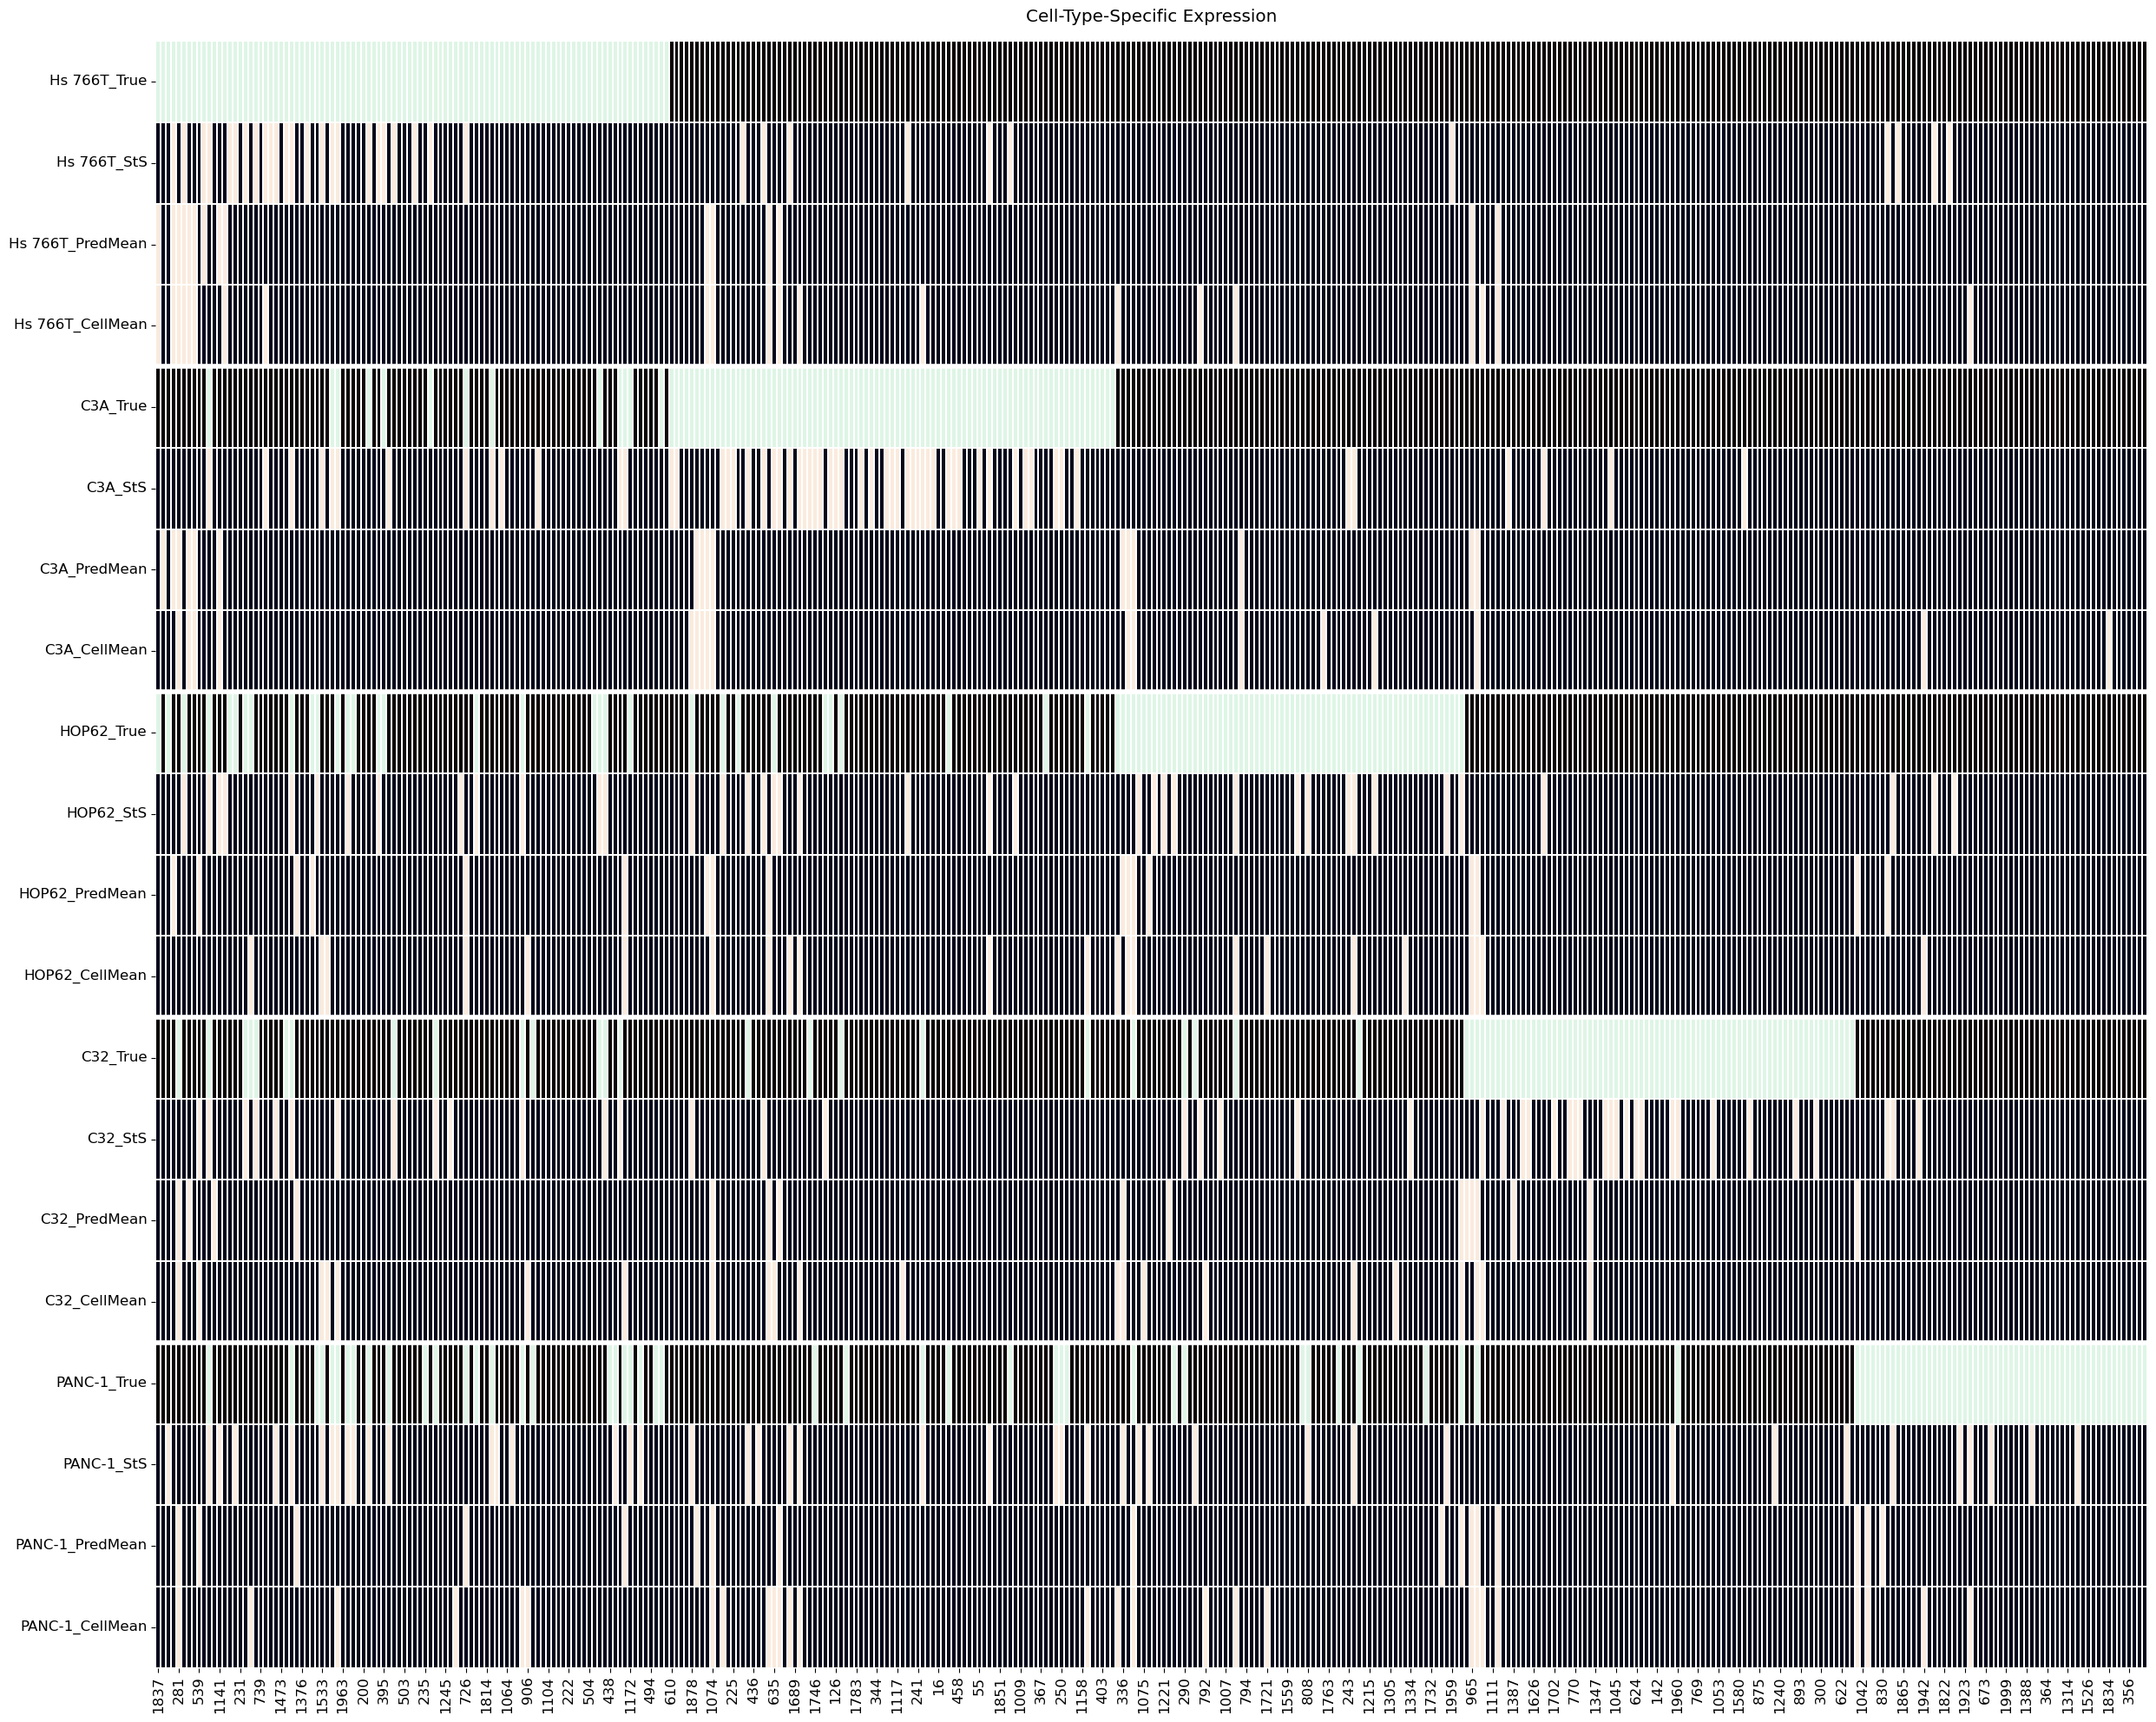

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = plot_df.T                       # rows are your sets
df = df.loc[:, ~df.columns.duplicated()]
special_rows = (df.reset_index().index.values % 4 == 0)    # 1-D boolean: which rows get palette #2

# ── build full-size masks ────────────────────────────────────────────────
# Repeat the row mask across all columns so the shape is (rows, cols)
mask_special   = np.tile(special_rows[:, None], (1, df.shape[1]))
mask_regular   = ~mask_special        # complement for the other pass

fig, ax = plt.subplots(figsize=(25, 20))

# 1️⃣ Regular rows (rocket)
sns.heatmap(
    df,
    cmap='rocket',
    vmin=0, vmax=1,
    mask=mask_special,               # hide special rows here
    linewidths=0.01, linecolor='white',
    cbar=False,
    ax=ax
)

# 2️⃣ Special rows (crest)
sns.heatmap(
    df,
    cmap='mako',
    vmin=0, vmax=1,
    mask=mask_regular,               # hide regular rows here
    linewidths=0.01, linecolor='white',
    cbar=False,
    ax=ax
)

# 3️⃣ Optional thick separators every four rows
for y in range(4, df.shape[0], 4):
    ax.hlines(y, *ax.get_xlim(), color='white', linewidth=4)

ax.set_title('Cell-Type-Specific Expression', pad=16)

plt.savefig('cell_type_specific_expression.svg')
plt.tight_layout()
plt.show()
